# Cardiovascular Disease Risk Dataset – EDA and Data Validation (Training Set Only)

This notebook performs exploratory data analysis (EDA) and **data validation** for the
*Cardiovascular Diseases Risk Prediction* dataset.

**Key principle:**

- First, **split** the data into training and test sets.
- All **visualizations, validation and preprocessing** are then performed **only on the training set**.
- Any preprocessing parameters (e.g. scaling, encodings) must be learned from the training data and only applied to the test data.


**Dataset basics**

- Rows: N (each row = one individual)
- Target: `Heart_Disease` (0 = No, 1 = Yes)
- Examples of predictors:
  - `Age_Category`: categorical age bands (18–24, …, 80+)
  - `Sex`: Female / Male
  - `General_Health`: ordinal 1–5
  - `BMI`, `Height_(cm)`, `Weight_(kg)` …

## 0. Setup

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(style="darkgrid")

## 1. Load the dataset (full data, structural checks only)

We load the dataset from the project root. At this stage we perform **only structural checks**:

- shape and column names,
- dtypes and a quick preview of the first rows.

No preprocessing or visualizations are done yet.


In [21]:
data_path = "Cardiovascular Diseases Risk Prediction Dataset export 2025-11-21 14-38-58.csv"

df = pd.read_csv(data_path)
print("Shape of the full dataset:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

display(df.head())
print("\nDtypes:")
print(df.dtypes)

Shape of the full dataset: (308854, 19)

Columns:
['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150,32.66,14.54,Yes,0,30,16,12
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165,77.11,28.29,No,0,30,0,4
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163,88.45,33.47,No,4,12,3,16
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180,93.44,28.73,No,0,30,30,8
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191,88.45,24.37,Yes,0,8,4,0



Dtypes:
General_Health                   object
Checkup                          object
Exercise                         object
Heart_Disease                    object
Skin_Cancer                      object
Other_Cancer                     object
Depression                       object
Diabetes                         object
Arthritis                        object
Sex                              object
Age_Category                     object
Height_(cm)                       int64
Weight_(kg)                     float64
BMI                             float64
Smoking_History                  object
Alcohol_Consumption               int64
Fruit_Consumption                 int64
Green_Vegetables_Consumption      int64
FriedPotato_Consumption           int64
dtype: object


## 2. Global data quality checks (before splitting)

These checks describe the raw data **before** any splitting or preprocessing:

- missing values per column,
- number of fully duplicated rows.

They do not learn any parameters and therefore do not violate the train/test separation rule.


In [22]:
# 2.1 Missing values per column
na_counts = df.isna().sum().sort_values(ascending=False)
print("Missing values by column:")
print(na_counts)

# 2.2 Fully duplicated rows
dup_count = df.duplicated().sum()
print(f"\nNumber of completely duplicated rows: {dup_count}")

Missing values by column:
General_Health                  0
Age_Category                    0
Green_Vegetables_Consumption    0
Fruit_Consumption               0
Alcohol_Consumption             0
Smoking_History                 0
BMI                             0
Weight_(kg)                     0
Height_(cm)                     0
Sex                             0
Checkup                         0
Arthritis                       0
Diabetes                        0
Depression                      0
Other_Cancer                    0
Skin_Cancer                     0
Heart_Disease                   0
Exercise                        0
FriedPotato_Consumption         0
dtype: int64

Number of completely duplicated rows: 80


### Comment on duplicated rows

The dataset contains fully duplicated rows. In this kind of medical survey, this does **not** necessarily
mean an error: different respondents can provide identical answers to all questions. Since there is no
personal identifier (ID), such rows represent different people with identical feature profiles.

Because most variables in this dataset are categorical, ordinal, or fall into coarse bins
(e.g., age categories, BMI ranges), the number of possible unique feature combinations is
relatively small. With many respondents, it is therefore expected that different individuals
share the exact same set of values across all features, resulting in duplicated rows.

Therefore, duplicates reflect **true sampling frequencies** and we **keep all rows** at this stage.


## 3. Define target and split into training / test sets

We now define the binary target variable and split the data into training and test sets.
All further validation, EDA and preprocessing will be performed **only on the training set**.


In [23]:
# Define target and features
target_col = "Heart_Disease"
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found")

y = df[target_col].copy()
X = df.drop(columns=[target_col])

print("Features shape (full):", X.shape)
print("Target shape (full):", y.shape)
print("Target unique values before mapping:", y.unique())

# Map Yes/No to 1/0 for later modeling
if y.dtype == 'O':
    y = y.map({'Yes': 1, 'No': 0})
    print("Target unique values after mapping:", y.unique())

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.10,
    random_state=42,
    stratify=y,
)

print("\nTraining features shape:", X_train.shape)
print("Test features shape:", X_test.shape)

print("\nTraining target distribution (proportions):")
print(y_train.value_counts(normalize=True).rename("proportion"))
print("\nTest target distribution (proportions):")
print(y_test.value_counts(normalize=True).rename("proportion"))

Features shape (full): (308854, 18)
Target shape (full): (308854,)
Target unique values before mapping: ['No' 'Yes']
Target unique values after mapping: [0 1]

Training features shape: (277968, 18)
Test features shape: (30886, 18)

Training target distribution (proportions):
0    0.919149
1    0.080851
Name: proportion, dtype: float64

Test target distribution (proportions):
0    0.919154
1    0.080846
Name: proportion, dtype: float64


## 4. Data validation on the training set

From this point on, **all analyses are restricted to the training data** (`X_train`, `y_train`).
This ensures that no information from the test set leaks into the modeling or preprocessing steps.


### 4.1 Target distribution (class imbalance)

We inspect the distribution of the target in the training set to quantify class imbalance.


In [24]:
target_counts = y_train.value_counts()
target_props = y_train.value_counts(normalize=True) * 100
print("Training target counts:\n", target_counts)
print("\nTraining target frequencies (%):\n", target_props.round(2))

Training target counts:
 0    255494
1     22474
Name: Heart_Disease, dtype: int64

Training target frequencies (%):
 0    91.91
1     8.09
Name: Heart_Disease, dtype: float64


### 4.2 Numeric ranges and outlier diagnostics (training set)

We examine numeric features in `X_train` and quantify potential outliers using the IQR rule.
Outliers are **not removed** at this stage; the goal is to document their presence.


In [25]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns in X_train:", numeric_cols)

def outlier_stats(series: pd.Series) -> dict:
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = (series < lower) | (series > upper)
    return {
        "q1": float(q1),
        "q3": float(q3),
        "iqr": float(iqr),
        "lower_fence": float(lower),
        "upper_fence": float(upper),
        "n_outliers": int(mask.sum()),
        "outlier_pct": float(mask.mean() * 100),
        "min": float(series.min()),
        "max": float(series.max()),
    }

outlier_summary_train = {col: outlier_stats(X_train[col]) for col in numeric_cols}
pd.DataFrame(outlier_summary_train).T

Numeric columns in X_train: ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']


,q1,q3,iqr,lower_fence,upper_fence,n_outliers,outlier_pct,min,max
Height_(cm),163.00,178.00,15.00,140.500,200.500,941.0,0.338528,91.00,241.00
Weight_(kg),68.04,95.25,27.21,27.225,136.065,6577.0,2.366100,24.95,293.02
BMI,24.21,31.82,7.61,12.795,43.235,8769.0,3.154680,12.02,99.17
Alcohol_Consumption,0.00,6.00,6.00,-9.000,15.000,32563.0,11.714658,0.00,30.00
Fruit_Consumption,12.00,30.00,18.00,-15.000,57.000,61433.0,22.100745,0.00,120.00
Green_Vegetables_Consumption,4.00,20.00,16.00,-20.000,44.000,10723.0,3.857638,0.00,128.00
FriedPotato_Consumption,2.00,8.00,6.00,-7.000,17.000,17589.0,6.327707,0.00,128.00


**Decision:** We will *not* drop IQR outliers at this stage. Instead, later modeling steps can:
- use robust models, or
- apply transformations (e.g. log for skewed variables), or
- explicitly cap extreme values if they are clearly erroneous.

### 4.3 Converting age categories into a numeric age variable

The variable `Age_Category` is ordinal (e.g., `18-24`, `25-29`, ..., `80+`). We define a numeric
approximation of age by mapping each category to the midpoint of its interval. The mapping is learned
from `X_train` and then applied to both `X_train` and `X_test`.


In [26]:
age_values = X_train['Age_Category'].unique()
print("Age_Category values in training set:", age_values)

def age_str_to_numeric(s: str) -> float:
    if '+' in s:
        base = int(s.replace('+', ''))
        return base + 2.5  # midpoint for open-ended interval
    lo, hi = s.split('-')
    return (int(lo) + int(hi)) / 2

age_map = {s: age_str_to_numeric(s) for s in age_values}
print("\nAge mapping (category -> numeric):")
for k, v in age_map.items():
    print(f"{k} -> {v}")

X_train['Age_num'] = X_train['Age_Category'].map(age_map)
X_test['Age_num'] = X_test['Age_Category'].map(age_map)

print("\nNumeric age summary (training set):")
print(X_train['Age_num'].describe())

Age_Category values in training set: ['45-49' '18-24' '30-34' '70-74' '65-69' '60-64' '80+' '75-79' '55-59'
 '50-54' '25-29' '40-44' '35-39']

Age mapping (category -> numeric):
45-49 -> 47.0
18-24 -> 21.0
30-34 -> 32.0
70-74 -> 72.0
65-69 -> 67.0
60-64 -> 62.0
80+ -> 82.5
75-79 -> 77.0
55-59 -> 57.0
50-54 -> 52.0
25-29 -> 27.0
40-44 -> 42.0
35-39 -> 37.0

Numeric age summary (training set):
count    277968.000000
mean         54.647323
std          17.779329
min          21.000000
25%          42.000000
50%          57.000000
75%          67.000000
max          82.500000
Name: Age_num, dtype: float64


### 4.4 Anthropometric consistency: BMI vs height and weight

We check whether the reported `BMI` is consistent with `Height_(cm)` and `Weight_(kg)` in the training set.
For each record we compute a theoretical BMI and compare it with the stored BMI values.


In [27]:
height_m = X_train['Height_(cm)'] / 100.0
bmi_calc = X_train['Weight_(kg)'] / (height_m ** 2)

bmi_diff = X_train['BMI'] - bmi_calc
print("BMI difference (reported - computed) summary:")
print(bmi_diff.describe())

large_dev = (bmi_diff.abs() > 2).mean() * 100
print(f"\nShare of records with |ΔBMI| > 2: {large_dev:.2f}%")

BMI difference (reported - computed) summary:
count    277968.000000
mean          0.001737
std           0.102123
min          -0.917988
25%          -0.077820
50%          -0.001719
75%           0.082821
max           0.828286
dtype: float64

Share of records with |ΔBMI| > 2: 0.00%


### 4.5 Category frequencies and rare levels (training set)

We examine the frequency of each category for categorical features in `X_train` to identify very rare
levels that might lead to unstable estimates in later modeling.


In [28]:
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns in X_train:", cat_cols)

freq_tables = {}
for col in cat_cols:
    counts = X_train[col].value_counts()
    props = X_train[col].value_counts(normalize=True) * 100
    freq_tables[col] = pd.DataFrame({'count': counts, 'percent': props.round(2)})

freq_tables

Categorical columns in X_train: ['General_Health', 'Checkup', 'Exercise', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Smoking_History']


{'General_Health':            count  percent
 Very Good  99356    35.74
 Good       85830    30.88
 Excellent  50355    18.12
 Fair       32243    11.60
 Poor       10184     3.66,
 'Checkup':                           count  percent
 Within the past year     215452    77.51
 Within the past 2 years   33470    12.04
 Within the past 5 years   15659     5.63
 5 or more years ago       12106     4.36
 Never                      1281     0.46,
 'Exercise':       count  percent
 Yes  215597    77.56
 No    62371    22.44,
 'Skin_Cancer':       count  percent
 No   250971    90.29
 Yes   26997     9.71,
 'Other_Cancer':       count  percent
 No   251149    90.35
 Yes   26819     9.65,
 'Depression':       count  percent
 No   222204    79.94
 Yes   55764    20.06,
 'Diabetes':                                              count  percent
 No                                          233232    83.91
 Yes                                          36133    13.00
 No, pre-diabetes or borderline dia

### 4.6 Face validity: heart disease prevalence by key risk factors (training set)

We check whether the dataset reflects clinically plausible patterns by looking at heart disease prevalence
across age, general health, smoking and exercise. All computations use only the training set.


A clinically plausible pattern should show **higher prevalence** among:

- older individuals,
- those reporting poorer general health,
- individuals who smoke,
- individuals with lower levels of physical activity.

Each of these is strongly associated with cardiovascular risk in clinical research. If the trends in
the dataset follow expected patterns, this provides strong evidence of face validity and ensures that the dataset
is reliable for modeling.



In [29]:
# DELETE IF YOU AGREE THAT WE SHOULD ONLY HAVE PLOTS
'''
train_df = X_train.copy()
train_df['Heart_Disease'] = y_train

def prevalence_table(col: str) -> pd.DataFrame:
    ct = pd.crosstab(train_df[col], train_df['Heart_Disease'], normalize='index') * 100
    return ct.rename(columns={0: "No_Heart_Disease_%", 1: "Heart_Disease_%"}).round(2)

for feature in ['Age_Category', 'General_Health', 'Smoking_History', 'Exercise']:
    if feature in train_df.columns:
        print(f"\nHeart disease prevalence by {feature} (training set):")
        display(prevalence_table(feature)
'''

'\ntrain_df = X_train.copy()\ntrain_df[\'Heart_Disease\'] = y_train\n\ndef prevalence_table(col: str) -> pd.DataFrame:\n    ct = pd.crosstab(train_df[col], train_df[\'Heart_Disease\'], normalize=\'index\') * 100\n    return ct.rename(columns={0: "No_Heart_Disease_%", 1: "Heart_Disease_%"}).round(2)\n\nfor feature in [\'Age_Category\', \'General_Health\', \'Smoking_History\', \'Exercise\']:\n    if feature in train_df.columns:\n        print(f"\nHeart disease prevalence by {feature} (training set):")\n        display(prevalence_table(feature)\n'

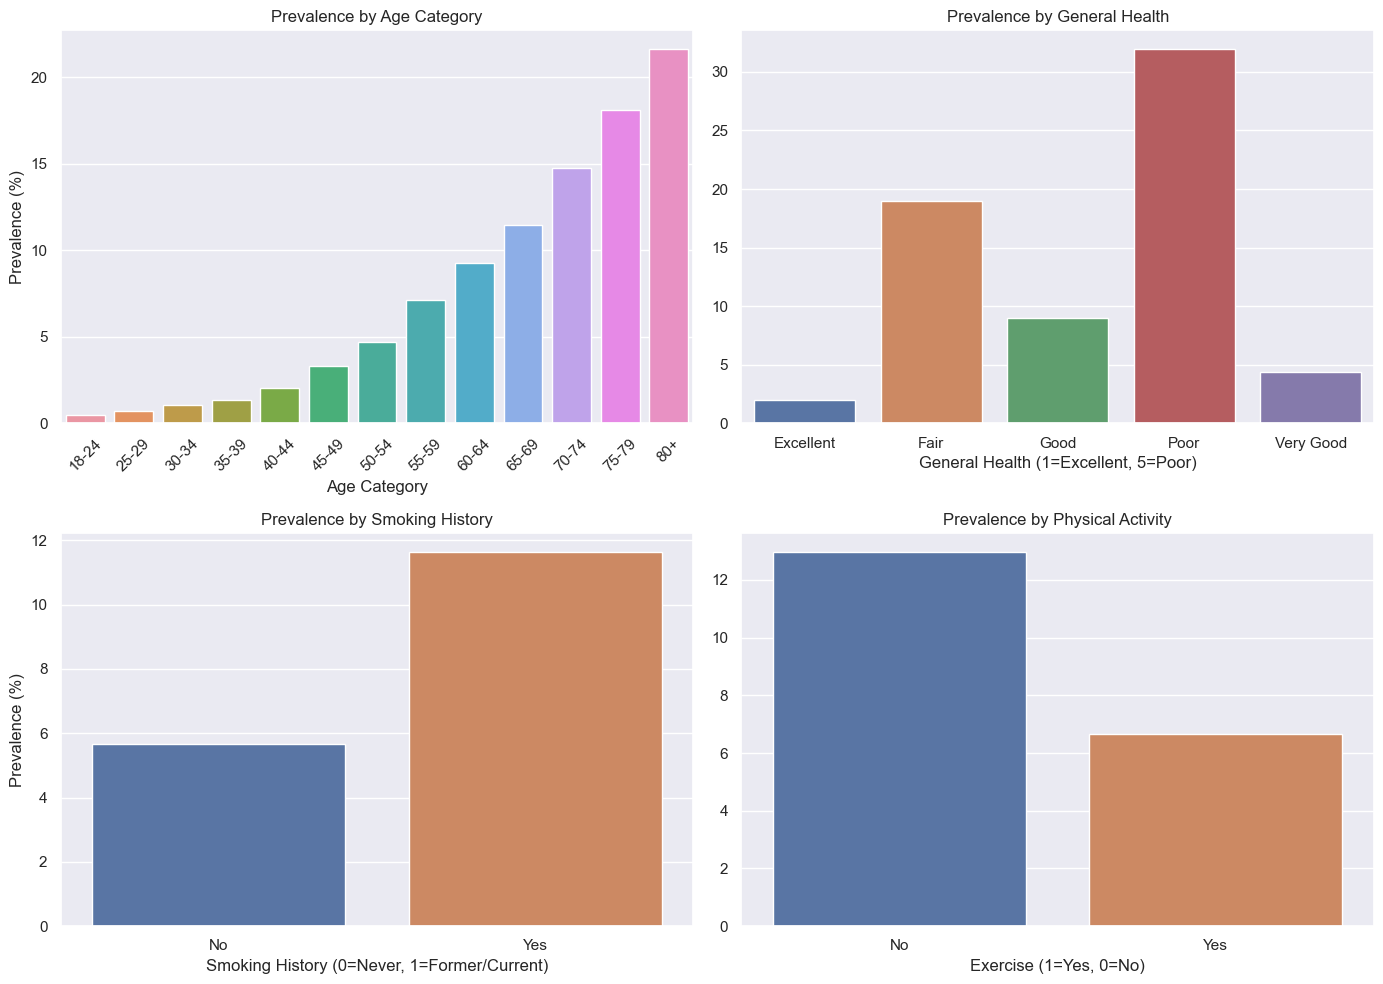

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# --- 1. Age Category ---
prev_age = prevalence_table("Age_Category").reset_index()
sns.barplot(data=prev_age, x="Age_Category", y="Heart_Disease_%", ax=axes[0])
axes[0].set_title("Prevalence by Age Category")
axes[0].set_xlabel("Age Category")
axes[0].set_ylabel("Prevalence (%)")
axes[0].tick_params(axis='x', rotation=45)

# --- 2. General Health ---
prev_gh = prevalence_table("General_Health").reset_index()
sns.barplot(data=prev_gh, x="General_Health", y="Heart_Disease_%", ax=axes[1])
axes[1].set_title("Prevalence by General Health")
axes[1].set_xlabel("General Health (1=Excellent, 5=Poor)")
axes[1].set_ylabel("")
axes[1].tick_params(axis='x')

# --- 3. Smoking History ---
prev_smoke = prevalence_table("Smoking_History").reset_index()
sns.barplot(data=prev_smoke, x="Smoking_History", y="Heart_Disease_%", ax=axes[2])
axes[2].set_title("Prevalence by Smoking History")
axes[2].set_xlabel("Smoking History (0=Never, 1=Former/Current)")
axes[2].set_ylabel("Prevalence (%)")
axes[2].tick_params(axis='x')

# --- 4. Exercise ---
prev_exercise = prevalence_table("Exercise").reset_index()
sns.barplot(data=prev_exercise, x="Exercise", y="Heart_Disease_%", ax=axes[3])
axes[3].set_title("Prevalence by Physical Activity")
axes[3].set_xlabel("Exercise (1=Yes, 0=No)")
axes[3].set_ylabel("")

plt.tight_layout()
plt.show()


### Interpretation

All four visualizations show patterns consistent with established cardiovascular research:

- **Age:** Heart disease prevalence increases steadily with age, reflecting one of the strongest known risk factors.  
- **General Health:** Individuals reporting poorer health exhibit sharply higher prevalence, supporting the variable’s reliability.  
- **Smoking History:** Smokers show higher rates of heart disease, matching epidemiological expectations.  
- **Exercise:** Regular physical activity corresponds to lower prevalence, demonstrating the expected protective effect.

The consistency of these trends provides strong evidence of face validity and confirms that the
dataset’s labels and features behave as expected. This supports its suitability for predictive
modeling and further analysis.


### 4.7 Train–test distribution comparison (no major covariate shift)

We compare key features between the training and test sets to verify that the random split did not introduce
a strong distribution shift.


In [31]:
# Numeric comparison for Age_num and BMI
for col in ['Age_num', 'BMI']:
    if col in X_train.columns:
        print(f"\nColumn: {col}")
        train_stats = X_train[col].describe()[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
        test_stats = X_test[col].describe()[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
        comp = pd.DataFrame({'train': train_stats, 'test': test_stats})
        display(comp)

# Categorical comparison for Sex and General_Health
for col in ['Sex', 'General_Health']:
    if col in X_train.columns:
        print(f"\nColumn: {col}")
        train_freq = X_train[col].value_counts(normalize=True).rename('train')
        test_freq = X_test[col].value_counts(normalize=True).rename('test')
        comp_cat = pd.concat([train_freq, test_freq], axis=1).fillna(0).round(3)
        display(comp_cat)


Column: Age_num


,train,test
mean,54.647323,54.724163
std,17.779329,17.857324
min,21.000000,21.000000
25%,42.000000,42.000000
50%,57.000000,57.000000
75%,67.000000,67.000000
max,82.500000,82.500000



Column: BMI


,train,test
mean,28.626982,28.619267
std,6.521177,6.532731
min,12.020000,12.160000
25%,24.210000,24.140000
50%,27.440000,27.440000
75%,31.820000,31.890000
max,99.170000,99.330000



Column: Sex


,train,test
Female,0.518,0.522
Male,0.482,0.478



Column: General_Health


,train,test
Very Good,0.357,0.357
Good,0.309,0.309
Excellent,0.181,0.181
Fair,0.116,0.115
Poor,0.037,0.037


### 4.8 Correlation redundancy summary (training set)

We list the strongest pairwise correlations between numeric features in `X_train` to identify potentially
redundant variables (e.g. BMI and weight). This complements the correlation heatmap shown later.


In [32]:
num_train = X_train.select_dtypes(include=[np.number])
corr_matrix = num_train.corr()

corr_pairs = []
cols = corr_matrix.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        corr_val = corr_matrix.iloc[i, j]
        corr_pairs.append((cols[i], cols[j], corr_val))

corr_df = pd.DataFrame(corr_pairs, columns=['feature_1', 'feature_2', 'corr'])
strong_corr = corr_df.reindex(corr_df['corr'].abs().sort_values(ascending=False).index)
strong_corr = strong_corr[strong_corr['corr'].abs() > 0.6]
strong_corr

,feature_1,feature_2,corr
7,Weight_(kg),BMI,0.860171


## 5. Distributions of numeric features (training set only)

We visualize the distributions of numeric features using only `X_train`. To keep the plot readable,
we show up to 7 features at once.


Numeric features (all): ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption', 'Age_num']
Will plot distributions for: ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']


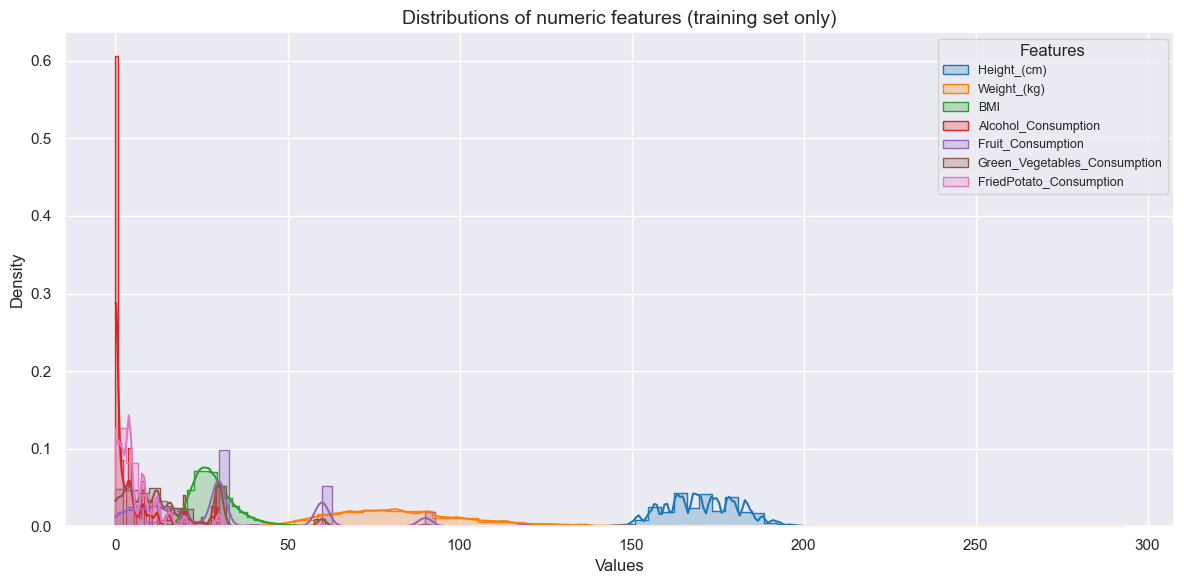

In [33]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric features (all):", numeric_cols)

max_features_to_plot = 7
numeric_cols_to_plot = numeric_cols[:max_features_to_plot]
print(f"Will plot distributions for: {numeric_cols_to_plot}")

plt.figure(figsize=(12, 6))
palette = sns.color_palette("tab10", len(numeric_cols_to_plot))

for col, color in zip(numeric_cols_to_plot, palette):
    sns.histplot(
        X_train[col].dropna(),
        bins=40,
        stat="density",
        kde=True,
        element="step",
        fill=True,
        alpha=0.25,
        label=col,
        color=color,
    )

plt.title("Distributions of numeric features (training set only)", fontsize=14)
plt.xlabel("Values", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Features", fontsize=9)
plt.tight_layout()
plt.show()

## 6. Overview of categorical features (training set only)

We inspect the frequency distribution of a subset of categorical features in `X_train` using bar plots.


Categorical features (all): ['General_Health', 'Checkup', 'Exercise', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Smoking_History']
Will plot counts for: ['General_Health', 'Checkup', 'Exercise', 'Skin_Cancer']


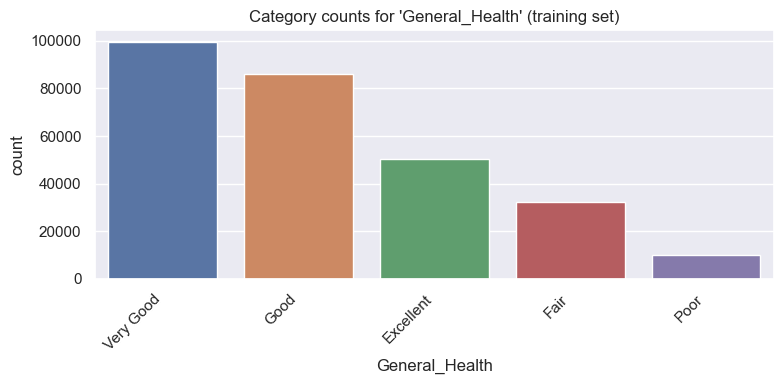

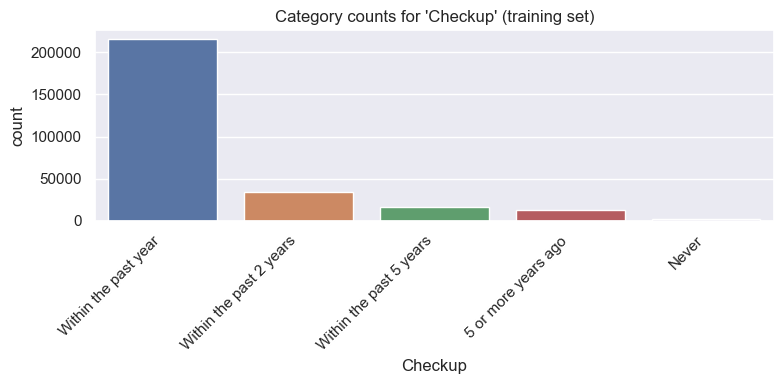

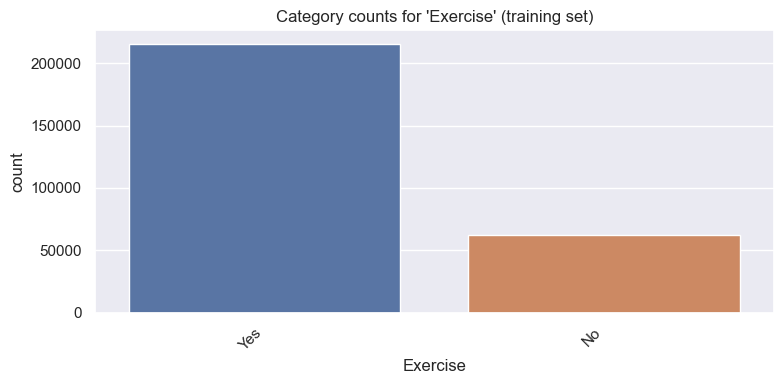

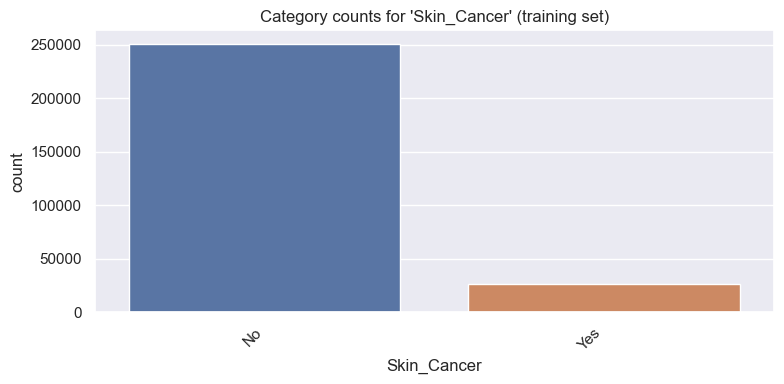

In [34]:
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical features (all):", cat_cols)

max_cat_to_plot = 4
cat_cols_to_plot = cat_cols[:max_cat_to_plot]
print(f"Will plot counts for: {cat_cols_to_plot}")

for col in cat_cols_to_plot:
    plt.figure(figsize=(8, 4))
    order = X_train[col].value_counts().index
    sns.countplot(data=X_train, x=col, order=order)
    plt.title(f"Category counts for '{col}' (training set)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

## 7. Correlation heatmap of numeric features (training set)

We compute the correlation matrix of numeric features in `X_train` and visualize it as a heatmap.
This complements the redundancy summary above.


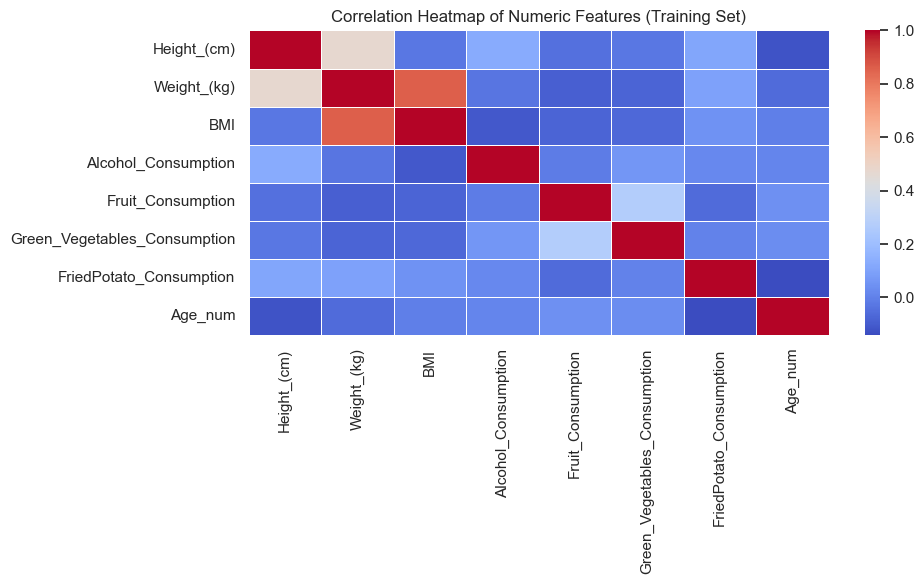

In [35]:
plt.figure(figsize=(10, 6))
corr = X_train.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features (Training Set)")
plt.tight_layout()
plt.show()

## 8. Height vs weight density (training set)

A 2D kernel density estimate (KDE) plot shows the joint distribution of `Height_(cm)` and `Weight_(kg)`
in the training set.


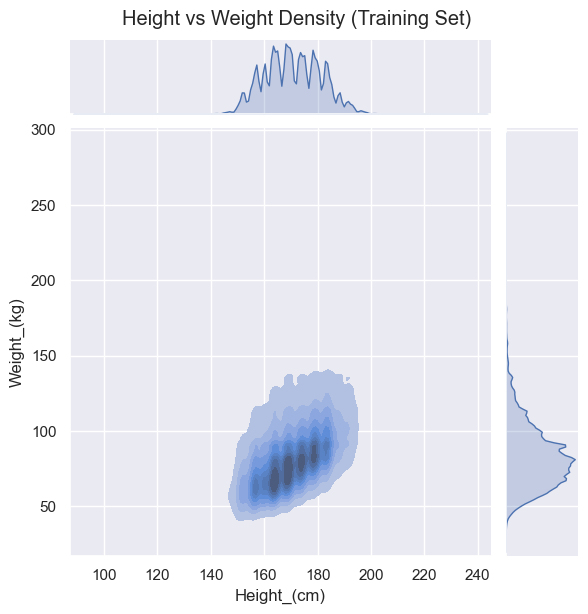

In [36]:
sns.jointplot(
    data=X_train,
    x="Height_(cm)",
    y="Weight_(kg)",
    kind="kde",
    fill=True
)
plt.suptitle("Height vs Weight Density (Training Set)", y=1.02)
plt.show()

## 9. General health across age groups (training set)

We explore how self-reported `General_Health` is distributed across different `Age_Category` groups
in the training data.


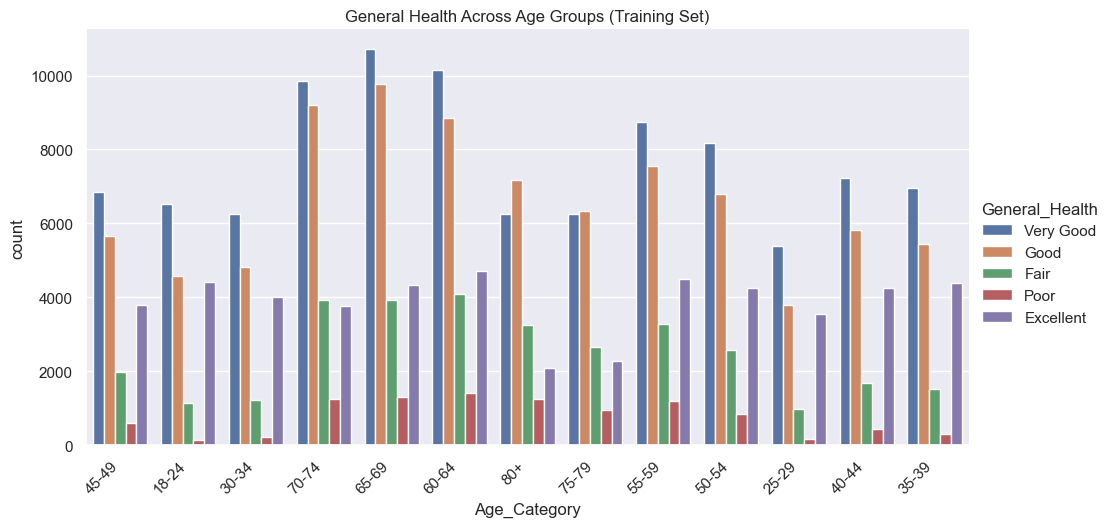

In [37]:
sns.catplot(
    data=X_train,
    x="Age_Category",
    hue="General_Health",
    kind="count",
    height=5,
    aspect=2
)
plt.title("General Health Across Age Groups (Training Set)")
plt.xticks(rotation=45, ha="right")
plt.show()

## 10. Exercise habits by sex (training set)

We create a stacked bar chart of `Exercise` habits by `Sex`, normalized within each sex group.


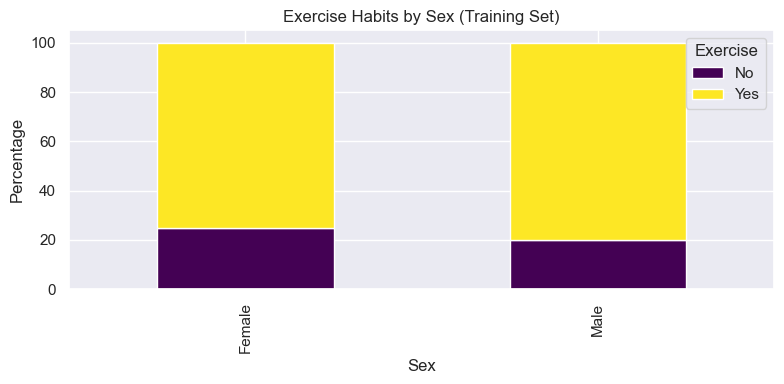

In [38]:
cross = pd.crosstab(X_train["Sex"], X_train["Exercise"], normalize='index') * 100
cross.plot(kind='bar', stacked=True, figsize=(8,4), colormap='viridis')
plt.ylabel("Percentage")
plt.title("Exercise Habits by Sex (Training Set)")
plt.legend(title="Exercise")
plt.tight_layout()
plt.show()

## 11. Boxplots of physical measurements (training set)

We summarize `Height_(cm)`, `Weight_(kg)` and `BMI` using boxplots to highlight their spread and potential
outliers in the training set.


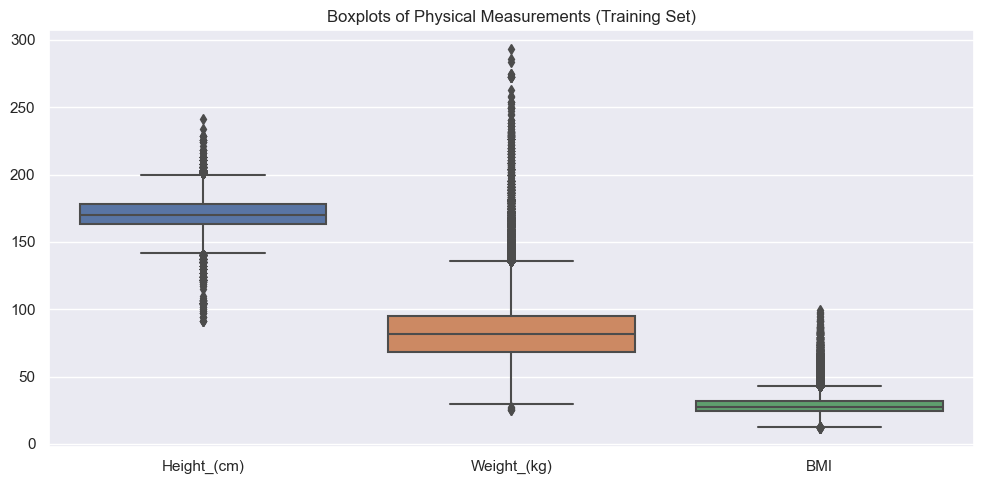

In [39]:
phys = ["Height_(cm)", "Weight_(kg)", "BMI"]

plt.figure(figsize=(10,5))
sns.boxplot(data=X_train[phys])
plt.title("Boxplots of Physical Measurements (Training Set)")
plt.tight_layout()
plt.show()

## Conclusion

**Summary**

- No obvious covariate shift between training and test sets.
- Target is moderately imbalanced (X% positive).
- Data shows clinically plausible relationships between age, general health, smoking, exercise and heart disease.
- Numeric features such as BMI, height and weight are highly correlated, so we may drop or regularize some in modeling.
- No catastrophic missingness; we can use simple imputers per feature group.

**Next steps**

- Define preprocessing pipelines (imputation, scaling, encoding) learned on `X_train`.
- Train baseline models (logistic regression, tree-based) with proper cross-validation.
- Evaluate calibration and discrimination on the held-out test set (`X_test`, `y_test`).
